<a href="https://colab.research.google.com/github/marmurr/Deep-Learning/blob/main/Deep_Learning_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Написати за допомогою Pytorch архітектуру Resnet, вона складається з:

окрема імплементація resnet блоку

окрема імплементація resnet layer

Конструктор має виглядати наступним чином

model = ResNet(architecture: Optional[int]=”18/32/50/101…”, layer:Optional[List[int]]=[2, 2, 2, 2])

Взяти датасет і натренувати побудований resnet та порівняти архітектури resnet10, resnet18, resnet32


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
class BasicResidualBlock(nn.Module):
    """
    A basic residual block with two convolutional layers, each followed by batch normalization and ReLU activation.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.adjust_dimensions = None
        if stride != 1 or in_channels != out_channels:
            self.adjust_dimensions = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        original_x = x
        if self.adjust_dimensions:
            original_x = self.adjust_dimensions(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x += original_x
        x = self.relu2(x)
        return x


In [ ]:
class ResidualLayer(nn.Module):
    def __init__(self, block_type, in_channels, out_channels, num_blocks, first_stride):
        super(ResidualLayer, self).__init__()
        strides = [first_stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block_type(in_channels, out_channels, stride))
            in_channels = out_channels

        self.blocks = nn.Sequential(*layers)

    def forward(self, x):
        return self.blocks(x)

In [ ]:
class CustomResNet(nn.Module):
    def __init__(self, block_type, num_classes=10, architecture='18'):
        super(CustomResNet, self).__init__()
        config = {'10': [1, 1, 1, 1], '18': [2, 2, 2, 2], '34': [3, 4, 6, 3]}
        num_blocks = config[architecture]

        self.initial_conv = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.initial_bn = nn.BatchNorm2d(64)
        self.initial_relu = nn.ReLU(inplace=True)
        self.initial_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = ResidualLayer(block_type, 64, 64, num_blocks[0], first_stride=1)
        self.layer2 = ResidualLayer(block_type, 64, 128, num_blocks[1], first_stride=2)
        self.layer3 = ResidualLayer(block_type, 128, 256, num_blocks[2], first_stride=2)
        self.layer4 = ResidualLayer(block_type, 256, 512, num_blocks[3], first_stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.initial_relu(x)
        x = self.initial_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
def initialize_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight)
        nn.init.constant_(module.bias, 0)
    elif isinstance(module, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)

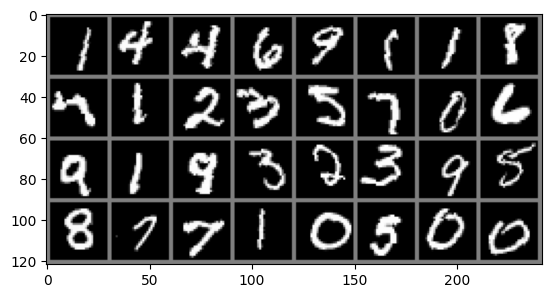

ResNet10 results:
Epoch 1, Batch 100: Loss 0.857
Epoch 1, Batch 200: Loss 0.347
Epoch 1, Batch 300: Loss 0.272
Epoch 1, Batch 400: Loss 0.229
Epoch 1, Batch 500: Loss 0.228
Epoch 1, Batch 600: Loss 0.207
Epoch 1, Batch 700: Loss 0.200
Epoch 1, Batch 800: Loss 0.158
Epoch 1, Batch 900: Loss 0.152
Epoch 1, Batch 1000: Loss 0.162
Epoch 1, Batch 1100: Loss 0.157
Epoch 1, Batch 1200: Loss 0.125
Epoch 1, Batch 1300: Loss 0.157
Epoch 1, Batch 1400: Loss 0.153
Epoch 1, Batch 1500: Loss 0.130
Epoch 1, Batch 1600: Loss 0.116
Epoch 1, Batch 1700: Loss 0.127
Epoch 1, Batch 1800: Loss 0.098
Epoch 2, Batch 100: Loss 0.102
Epoch 2, Batch 200: Loss 0.125
Epoch 2, Batch 300: Loss 0.101
Epoch 2, Batch 400: Loss 0.092
Epoch 2, Batch 500: Loss 0.123
Epoch 2, Batch 600: Loss 0.108
Epoch 2, Batch 700: Loss 0.107
Epoch 2, Batch 800: Loss 0.102
Epoch 2, Batch 900: Loss 0.106
Epoch 2, Batch 1000: Loss 0.102
Epoch 2, Batch 1100: Loss 0.108


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Displaying some training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

# Training function
def train(model, trainloader, device, n_epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if (i + 1) % 100 == 0:
                print(f'Epoch {epoch + 1}, Batch {i + 1}: Loss {running_loss / 100:.3f}')
                running_loss = 0.0

# Testing function
def test(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

# Initializing and training different models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet10 = CustomResNet(BasicResidualBlock, num_classes=10, architecture='10').apply(initialize_weights)
resnet18 = CustomResNet(BasicResidualBlock, num_classes=10, architecture='18').apply(initialize_weights)

print("ResNet10 results:")
train(resnet10, trainloader, device, n_epochs=8)
test(resnet10, testloader, device)

print("ResNet18 results:")
train(resnet18, trainloader, device, n_epochs=10)
test(resnet18, testloader, device)